
# Brain encoding

Encoding models try to predict neuronal activity using information from presented stimuli, like an image or sound. Where decoding goes from brain data to real-world stimulus, encoding goes the other direction.

They learn to transform stimuli (typically) into neural response signals. Such models help us understand the relationship between the stimuli and the brain signals (brain's "code").   

Some questions that encoding models attempt to address :


* Does the variation in the response depend on the stimulus?


* How well do the responses ‘encode’ the stimuli?


* How well are the responses ‘explained’ by the stimuli?


* Can some responses be explained by specific stimuli?


* How can we quantify the dependence of responses on the stimuli?


---

In this tutorial, we will consider a study based on Miyawaki et al. 2008. This is based on the nilearn [tutorial on encoding](https://nilearn.github.io/auto_examples/02_decoding/plot_miyawaki_encoding.html).

## Miyawaki et al. 2008 Study

This example partly reproduces the encoding model presented in Miyawaki, Y., Uchida, H., Yamashita, O., Sato, M.A., Morito, Y., Tanabe, H.C., Sadato, N. and Kamitani, Y., 2008. [`Visual image reconstruction from human brain activity using a combination of multiscale local image decoders`](http://www.cell.com/neuron/abstract/S0896-6273%2808%2900958-6) - *Miyawaki, Y., Uchida, H., Yamashita, O., Sato, M. A., Morito, Y., Tanabe, H. C., ... & Kamitani, Y. Neuron, 60(5), 915-929.*


Participants were shown images, which consisted of random 10x10 binary (either black or white) pixels, and the corresponding fMRI activity was recorded. We will try to predict the activity in each voxel from the binary pixel-values of the presented images. 


We will explore how to build such an **encoding model** in nilearn, predicting **fMRI data** from **visual stimuli**, using the dataset from [`Miyawaki et al., 2008`](http://www.cell.com/neuron/abstract/S0896-6273%2808%2900958-6).





We will first prepare the data for training a model. Then we will understand the regression model and the scoring metric before proceeding to fit the encoding model on the data.

We will evaluate the predictability of the activity at different voxels from the images. We shall explore the nature of prediction and plot these scores as brain maps to draw some inferences. 

Then we extract the receptive fields for a set of voxels to see which pixel location a voxel is most sensitive to. We attempt to understand the relationship between the stimuli image pixels and the voxel activities.


## Basic Imports

In [2]:
import numpy as np

import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Loading the data



The dataset is readily available in nilearn and can be imported directly. 

It can be loaded in the following way.

In [3]:
from nilearn.datasets import fetch_miyawaki2008

dataset = fetch_miyawaki2008()


Dataset created in /root/nilearn_data/miyawaki2008



Downloaded 136560640 of 161069109 bytes (84.8%,    0.9s remaining) ...done. (6 seconds, 0 min)
Extracting data from /root/nilearn_data/miyawaki2008/4356183cd5ae215342603c6edeb89f54/miyawaki2008.tgz..... done.


In [4]:
dataset

{'background': '/root/nilearn_data/miyawaki2008/bg.nii.gz',
 'description': b"Miyawaki 2008\n\n\nNotes\n-----\nCollection of result images from MVPA investigation of the human visual systems.\n\nThis :term:`fMRI` study reconstructed visual images by combining local\nimage bases of multiple scales. Their :term:`contrasts<contrast>` were independently\ndecoded from :term:`fMRI` activity by selecting important :term:`voxels<voxel>` and\ncapitalizing on their correlation structure.\n\nContent\n-------\n    :'label': Paths to text files containing session and target data\n    :'func': Paths to nifti files with :term:`BOLD` data\n    :'mask': Path to general mask nifti that defines target volume in visual cortex\n    :'mask_roi': List of paths to images with specific data ('RH' for right hemisphere, 'LH' for left hemisphere, 'Vxxx' denote visual areas)\n\n\nReferences\n----------\nFor more information on this dataset's structure, see\nhttp://www.cns.atr.jp/dni/en/downloads/ fmri-data-set-for

## Preparing the training data

### Making a list of the necessary files

We only use the training data of this study,
where random binary images were shown.



In [5]:
# Training data starts after the first 12 files

fmri_random_runs_filenames = dataset.func[12:]
stimuli_random_runs_filenames = dataset.label[12:]

In [6]:
fmri_random_runs_filenames

['/root/nilearn_data/miyawaki2008/func/data_random_run01.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run02.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run03.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run04.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run05.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run06.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run07.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run08.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run09.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run10.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run11.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run12.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run13.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run14.nii.gz',
 '/root/nilearn_data/miyawaki2008/func/data_random_run15.nii.gz',
 '/root/ni

In [7]:
stimuli_random_runs_filenames

['/root/nilearn_data/miyawaki2008/label/data_random_run01_label.csv',
 '/root/nilearn_data/miyawaki2008/label/data_random_run02_label.csv',
 '/root/nilearn_data/miyawaki2008/label/data_random_run03_label.csv',
 '/root/nilearn_data/miyawaki2008/label/data_random_run04_label.csv',
 '/root/nilearn_data/miyawaki2008/label/data_random_run05_label.csv',
 '/root/nilearn_data/miyawaki2008/label/data_random_run06_label.csv',
 '/root/nilearn_data/miyawaki2008/label/data_random_run07_label.csv',
 '/root/nilearn_data/miyawaki2008/label/data_random_run08_label.csv',
 '/root/nilearn_data/miyawaki2008/label/data_random_run09_label.csv',
 '/root/nilearn_data/miyawaki2008/label/data_random_run10_label.csv',
 '/root/nilearn_data/miyawaki2008/label/data_random_run11_label.csv',
 '/root/nilearn_data/miyawaki2008/label/data_random_run12_label.csv',
 '/root/nilearn_data/miyawaki2008/label/data_random_run13_label.csv',
 '/root/nilearn_data/miyawaki2008/label/data_random_run14_label.csv',
 '/root/nilearn_data

### fMRI data : Preprocessing, Masking and Data extraction

We can use `nilearn.input_data.MultiNiftiMasker` to load the fMRI
data, clean and mask it.



In [8]:
import numpy as np
from nilearn.input_data import MultiNiftiMasker

masker = MultiNiftiMasker(mask_img=dataset.mask, detrend=True,
                          standardize=True)
masker.fit()
fmri_data = masker.transform(fmri_random_runs_filenames)

For each run, the dimensions of the masked data matrix is : 

`#samples` x `#voxels`

In [9]:
print('# runs in fmri data = ',len(fmri_data))

# runs in fmri data =  20


In [10]:
print('Dimensions of fmri data (#samples, #voxels) = ', fmri_data[0].shape)

Dimensions of fmri data (#samples, #voxels) =  (145, 5438)


Let's take a look at some of these BOLD response timecourses:

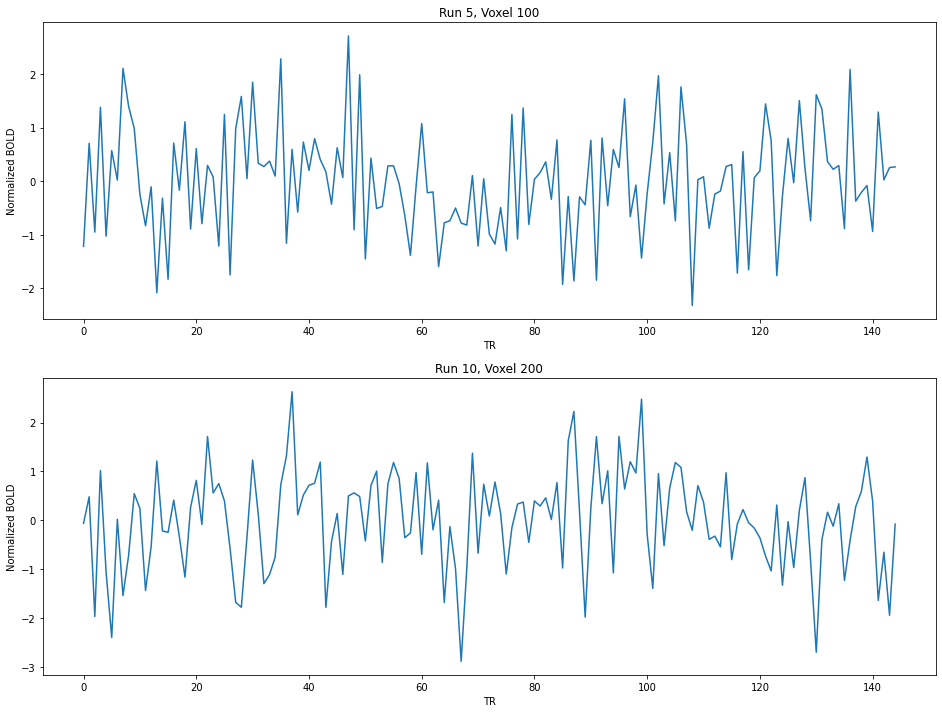

In [11]:
import matplotlib.pyplot as plt

runs = [5,10]
voxels = [100,200]

num_voxels = len(voxels)

plt.figure(figsize=(16,6*num_voxels))

for i in range(num_voxels):
  plt.subplot(num_voxels, 1, i+1)
  plt.xlabel('TR')
  plt.ylabel('Normalized BOLD')
  plt.title('Run {:d}, Voxel {:d}'.format(runs[i],voxels[i]))
  plt.plot(fmri_data[runs[i]][:,voxels[i]]);

### Stimuli data: Data Extraction


In [12]:
stimulus_shape = (10, 10)

# We load the visual stimuli from csv files
stimuli_data = []
for stimulus_run in stimuli_random_runs_filenames:
    stimuli_data.append(np.reshape(np.loadtxt(stimulus_run,
                              dtype=np.int, delimiter=','),
                              (-1,) + stimulus_shape, order='F'))

For each run, the dimensions of the masked data matrix is : 

`#samples` x `#voxels`

In [13]:
print('# runs in stimuli data = ',len(stimuli_data))

# runs in stimuli data =  20


In [14]:
print('Dimensions of stimuli data (#samples, image_height, image_width) = ', stimuli_data[0].shape)

Dimensions of stimuli data (#samples, image_height, image_width) =  (145, 10, 10)


Let's take a look at some of these binary images:



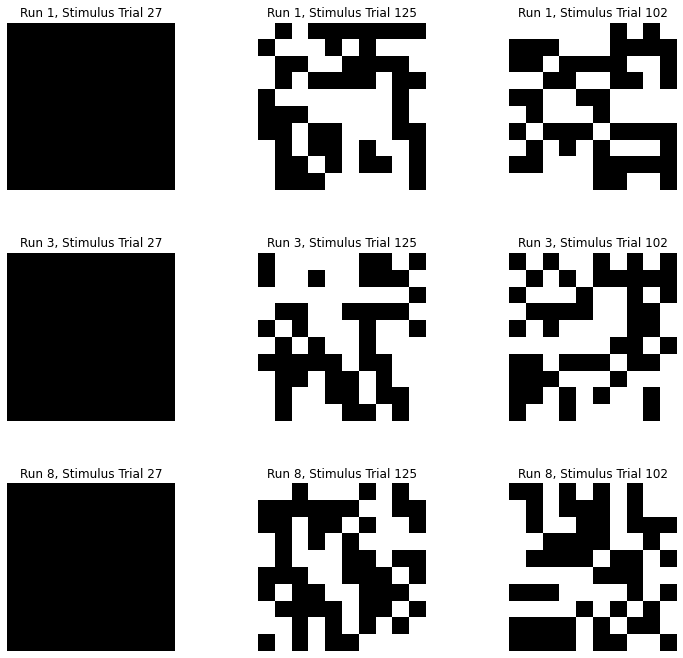

In [15]:
import matplotlib.pyplot as plt

runs = [1,3,8]
trials = [27,125,102]

num_runs = len(runs)
num_images = len(trials)

subplot_index = 1

plt.figure(figsize=(4*num_images, 4*num_runs))

for i in range(num_runs):
  for j in range(num_images):
    plt.subplot(num_runs, num_images, subplot_index)
    plt.imshow(stimuli_data[runs[i]][trials[j]], interpolation='nearest', cmap='gray')
    plt.axis('off')
    plt.title('Run {}, Stimulus Trial {}'.format(runs[i],trials[j]))
    subplot_index += 1

plt.subplots_adjust(wspace=0.5)

### Creating the input and target matrices for training

The input matrix and target matrix required for fitting the encoding model are prepared as follows:

As fMRI BOLD is a very slow signal, we ensure that the fMRI response data corresponds to the stimulus image shown at a given time by shifting the output sequence by a fixed number of steps (=2)

* We get rid of the fMRI data of the first 2 trials (TRs) is each run
* We remove the stimuli data of the last 2 trials (TRs) for to offset this delay.

* Both `fmri_data` and `stimuli_data` that are lists of numpy arrays are packaged into a numpy array.

In [16]:
# Delay chosen based on the TR duration to expect a hemodynamic response

delay_trials = 2

fmri_data = np.vstack([fmri_run[delay_trials:] for fmri_run in fmri_data])
stimuli_data = np.vstack([stimuli_run[:-delay_trials] for stimuli_run in stimuli_data]).astype(float)

Shape of the feature (data) and target matrices

In [17]:
print('stimuli_data.shape =',stimuli_data.shape)
print('fmri_data.shape =',fmri_data.shape)

stimuli_data.shape = (2860, 10, 10)
fmri_data.shape = (2860, 5438)


Each sample in `stimuli_data` has 2 components and this needs to converted to one before fitting the model.

`(10,10)` dimensions need to be flattened into 100-dimensional vectors.

In [18]:
# Flatten the stimuli

stimuli_data = np.reshape(stimuli_data, (-1, stimulus_shape[0] * stimulus_shape[1]))

print('stimuli_data.shape =',stimuli_data.shape)

stimuli_data.shape = (2860, 100)


## Building the encoding models



We can now proceed to build a simple **voxel-wise encoding model** using [Ridge regression](http://en.wikipedia.org/wiki/Tikhonov_regularization).

For each voxel we fit an independent regression model, using the pixel-values of the visual stimuli to predict the BOLD activity in this voxel.

We need to understand the model and a way to score our predictions to quantify the estimation.

### Ridge Regression Model

For the learning task in encoding, the data matrix for training is not always ideal.

Especially in most neroimaging studies, it is very common the have the number of samples of the stimuli lesser the dimensionality of the data.

This causes problems in fitting the model and the computations involved. The training might not be able to yield a good model.

A better version of the linear regression that handles such issues better is Ridge. 


The analytical solution to compute the is given by :
$$ \mathbf{\beta} =  (\mathbf{X}^{T}\mathbf{X} + \alpha \mathbf{I})^{-1} \mathbf{X}^{T} \mathbf{y}$$

The $\alpha$ value controls the stability of this estimation and needs to be carefully chosen.

The parameter matrix $\mathbf{\beta}$ can also be calculated using optimization.

The mean squared error ($MSE$) objective function of ordinary linear regression is augmented with an extra term to reduce the magnitude of the coefficients ${\beta_i}^{(k)}$ in the matrix $\mathbf{\beta}$.  

We will use the [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) model from scikit-learn.

### $R^2$ score for evaluation of regression

For the actual target values ${y}_i$ the regression model attempts to predict a good estimates $\hat{y}_i$ and the error of such a model prediction can be expressed by the mean squared error ($MSE$) which is the mean of all the squared error terms.


$$MSE(y,\hat{y})~=~ \frac{1}{n} \sum_{i=1}^{n}~(y_i - \hat{y}_i)^2 ~=~ \frac{1}{n} ~SSE_{regression}$$


It is an absolute value and thus difficult to infer the quality of the regression fit. The $MSE$ of different model fits can practically be any real number.



The mean response of the target values can be considered as a good baseline for the regression model to estimate. So, such a baseline model always predicts he value $\bar{y}$ for all inputs where $\bar{y} ~=~ \frac{1}{n} \sum_{i=1}^{n}~y_i$.

We expect that any model that we train to perform atleast as good as thise mean baseline model. That is to say that if a model always outputs the mean of the responses in the training set as its prediction, the sum of squared errors of such a model is given by $SSE_{total} ~=~\sum_{i=1}^{n}~(y_i - \bar{y})^2$ which is precisely the variance of the values $y_i$

This value is the upper limit for the error that a model can incur in its predictions. We can expres the error of any model as a quantity relative to this.

<br/>

$$R^2(y,\hat{y})~=~ 1 - \frac{\sum_{i=1}^{n}~(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}~(y_i - \bar{y})^2}$$

<br/>

$$R^2(y,\hat{y})~=~ 1 - \frac{SSE_{regression}}{SSE_{total}} ~=~ 1 - \frac{Unexplained~Variance}{Total~Variance}  ~=~ \frac{Explained~Variance}{Total~Variance}$$


This quantity $R^2$ (that is equivalently referred to as R2) is a relative measure that is usually between $0$ and $1$ and can be interpreted as aprportion of explained variance (can also be expressed as a percentage).

This score is very useful in determining if 

We make use of the [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) function in scikit-lean to compute this for each voxel during the model evaluation.

### Cross-Validation

The evaluation of regression model used in encoding needs to be done for truly “unseen” inputs. Otherwise, the model could easily overfit to the stimuli/features seen during training and could perform poorly in general and can signal an association that is not true.


Cross-validation methods (k-Fold, LOOCV, etc) can be used to get a good estimate of the generalization of prediction of the regression model. As these methods fit models several times and average the results, these are more reliable.


The [`KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class in scikit-learn helps us create the splits for thse different folds.

### Training the model

In [19]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

Using 10-fold cross-validation, we partition the data into 10 'folds'. 

We hold out each fold of the data for testing, then fit a ridge regression to the remaining 9/10 of the data, using `stimuli_data` as predictors and `fmri_data` as targets, and create predictions for the held-out 10th fold.

In each fold, we compute the $R^2$ scores of the predictions at each voxel and store the values for further analysis.



In [20]:
from sklearn.metrics import r2_score

cv = KFold(n_splits=10)

scores = []
for fold, (train, test) in enumerate(cv.split(X=stimuli_data)):
    print('fold = [{:d}] :: #train samples = {:d}, #test samples = {:d}'.format(fold,len(train),len(test)))

    # create a ridge model
    model = Ridge(alpha=100.)

    # train the Ridge model on the training set
    model.fit(stimuli_data[train], fmri_data[train])

    # and predict the fMRI activity for the test set
    predictions = model.predict(stimuli_data[test])

    # we compute how much variance our encoding model explains in each voxel
    scores.append(r2_score(fmri_data[test], predictions, multioutput='raw_values'))

fold = [0] :: #train samples = 2574, #test samples = 286
fold = [1] :: #train samples = 2574, #test samples = 286
fold = [2] :: #train samples = 2574, #test samples = 286
fold = [3] :: #train samples = 2574, #test samples = 286
fold = [4] :: #train samples = 2574, #test samples = 286
fold = [5] :: #train samples = 2574, #test samples = 286
fold = [6] :: #train samples = 2574, #test samples = 286
fold = [7] :: #train samples = 2574, #test samples = 286
fold = [8] :: #train samples = 2574, #test samples = 286
fold = [9] :: #train samples = 2574, #test samples = 286


### Analyzing the predictions 

We will consider the predicted signals from the last fold of the k-fold that is found in the `predictions` variable and take the index values from the actual `fmri_data` that correspond to the original data.

From this we will consider 1 run from the test set of the final fold (which contains 2 runs).


In [21]:
#Extract only the first run from the test set and predictions

actual = fmri_data[test[:len(test)//2]]

predicted = predictions[:len(predictions)//2,:]

print('   actual.shape (#TRs,#voxels) = ',actual.shape)
print('predicted.shape (#TRs,#voxels) = ',predicted.shape)

   actual.shape (#TRs,#voxels) =  (143, 5438)
predicted.shape (#TRs,#voxels) =  (143, 5438)


We will plot the predicted BOLD signals along with the actual BOLD signals for different voxels as a timecourse visualization.

Note that some voxels have a relatively better prediction (voxels 1950, 1951, 1952,etc.), while few others have very bad predictions (voxels 0, 1, 2, 840, 841, etc).

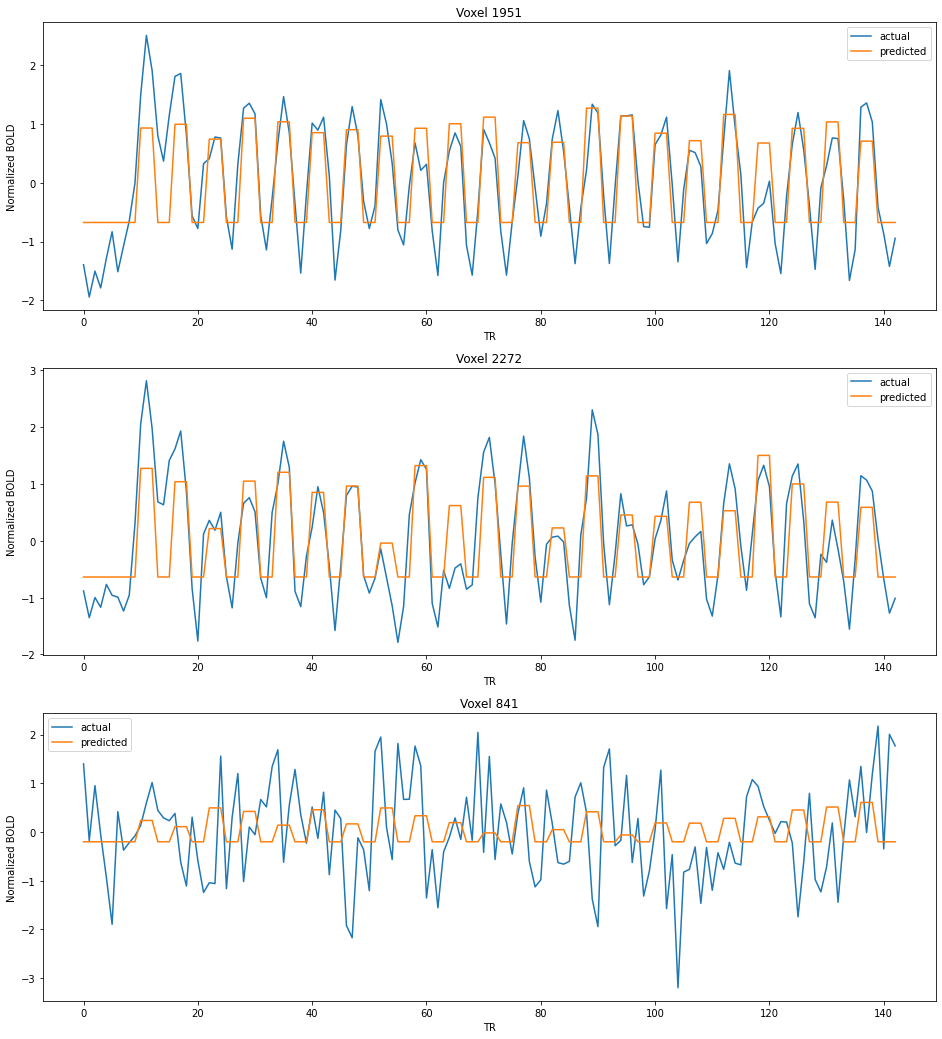

In [22]:
import matplotlib.pyplot as plt

voxels = [1951,2272,841]

num_voxels = len(voxels)

plt.figure(figsize=(16,6*num_voxels))

for i in range(num_voxels):
  plt.subplot(num_voxels, 1, i+1)
  plt.xlabel('TR')
  plt.ylabel('Normalized BOLD')
  plt.title('Voxel {:d}'.format(voxels[i]))
  plt.plot(actual[:,voxels[i]], label='actual')
  plt.plot(predicted[:,voxels[i]], label='predicted')
  plt.legend();

#### Scatter Plot of actual vs predicted values

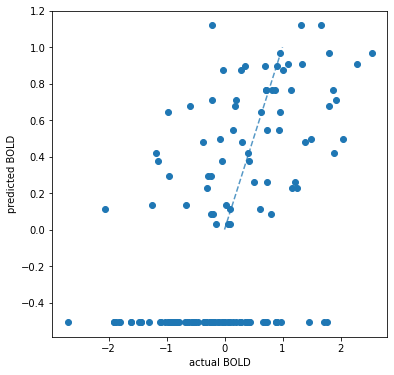

In [23]:
voxel = 1956

plt.figure(figsize=(6,6))
plt.ylabel('predicted BOLD')
plt.xlabel('actual BOLD')

lims = [
    np.min([plt.xlim(), plt.ylim()]),  # min of both axes
    np.max([plt.xlim(), plt.ylim()]),  # max of both axes
]

# x=y line for reference
plt.plot(lims, lims, '--', alpha=0.75, zorder=0)

plt.scatter(actual[:,voxel],predicted[:,voxel]);

Computing the $R^2$ score for a specific voxel.

The Pearson r is also computed for reference.

In [24]:
from scipy.stats import pearsonr

voxel = 1951

pearson_r, _  = pearsonr(actual[:,voxel],predicted[:,voxel])
r2 = r2_score(actual[:,voxel],predicted[:,voxel])

print('Pearson r at voxel {} = {:.3f}'.format(voxel,pearson_r))
print('R2 score at voxel  {} = {:.3f}'.format(voxel,r2))

Pearson r at voxel 1951 = 0.811
R2 score at voxel  1951 = 0.657


## Mapping the encoding scores on the brain







To plot the scores onto the brain, we create a Nifti1Image containing the scores and then threshold it:


### Computation of the score map and generating the brain image

The `masker` object used to map the voxels to the data matrix is reused to inverse transform the score matrix to the brain volumne.  

In [25]:
from nilearn.image import threshold_img

# Average the score maps accross folds
score_map = np.mean(scores, axis=0)

# Ignore the negative score values 
score_map[score_map < 0] = 0

# Bring the scores into the shape of the background brain
score_map_img = masker.inverse_transform(score_map)

thresholded_score_map_img = threshold_img(score_map_img, threshold=1e-6, copy=False)

The size of the `score_map` represents the number of voxels for which the scores have been computed.

In [26]:
print('The score_map is of size = ',score_map.shape)

The score_map is of size =  (5438,)


Finding the voxel with the best prediction

In [27]:
best_score = np.max(score_map)
best_voxel_ix = np.argmax(score_map)

print('Best voxel {} with score {:.4f}'.format(best_voxel_ix,best_score))

Best voxel 1951 with score 0.6006


Finding top k voxels with the best predictive scores.

In [28]:
import pandas as pd

# Number of top/bottom voxels to select
k = 10

# Pick the top voxel indexes and their scores
top_voxels = np.argsort(score_map)[:-(k+1):-1]
top_scores = score_map[top_voxels]

# Organize the data into a dataframe for better visualization
df = pd.DataFrame()
df['voxel'] = top_voxels.astype(int)
df['score'] = top_scores.round(2)
df.index += 1
df

voxel  score
1    1951   0.60
2    2272   0.60
3    1780   0.60
4    2284   0.58
5    2282   0.56
6    1411   0.56
7    1424   0.56
8    2120   0.55
9    1573   0.55
10   1588   0.55

#### Histogram of the $R^2$ scores

We notice that only a small minority of voxels have higher $R^2$ score and these are the voxels that are more predictive for the input features.

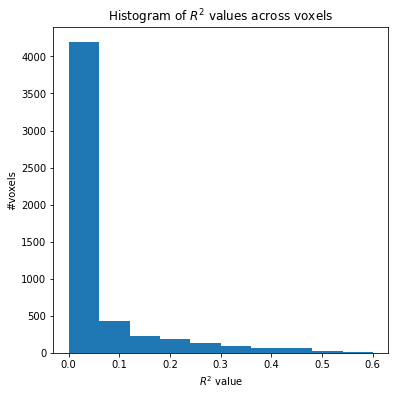

In [29]:
plt.figure(figsize=(6,6))
plt.xlabel(r'$R^2$ value')
plt.ylabel('#voxels')
plt.title(r'Histogram of $R^2$ values across voxels')
plt.hist(score_map);

### Plotting the score map brain image

We can plot first plot the statistical map of the $R^2$ scores in an interactive plot.


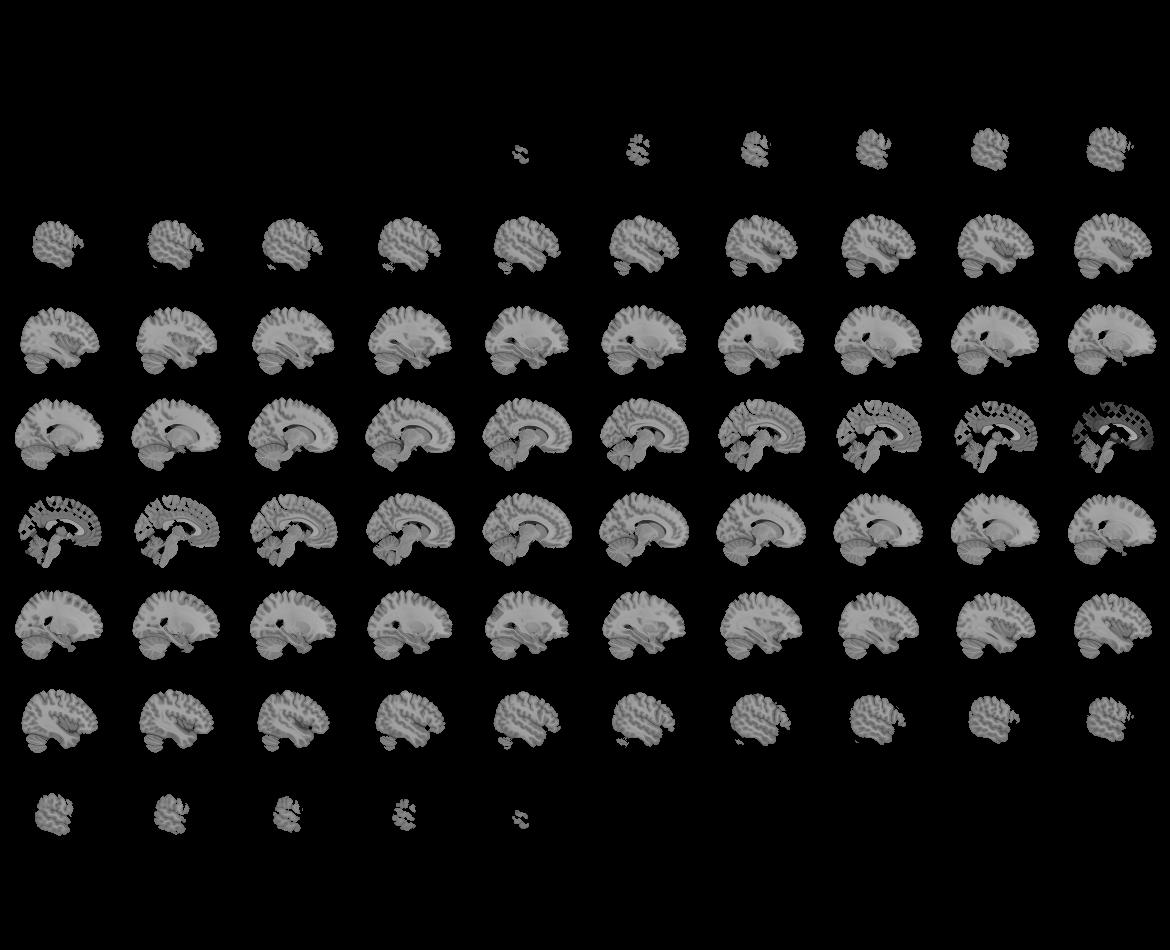
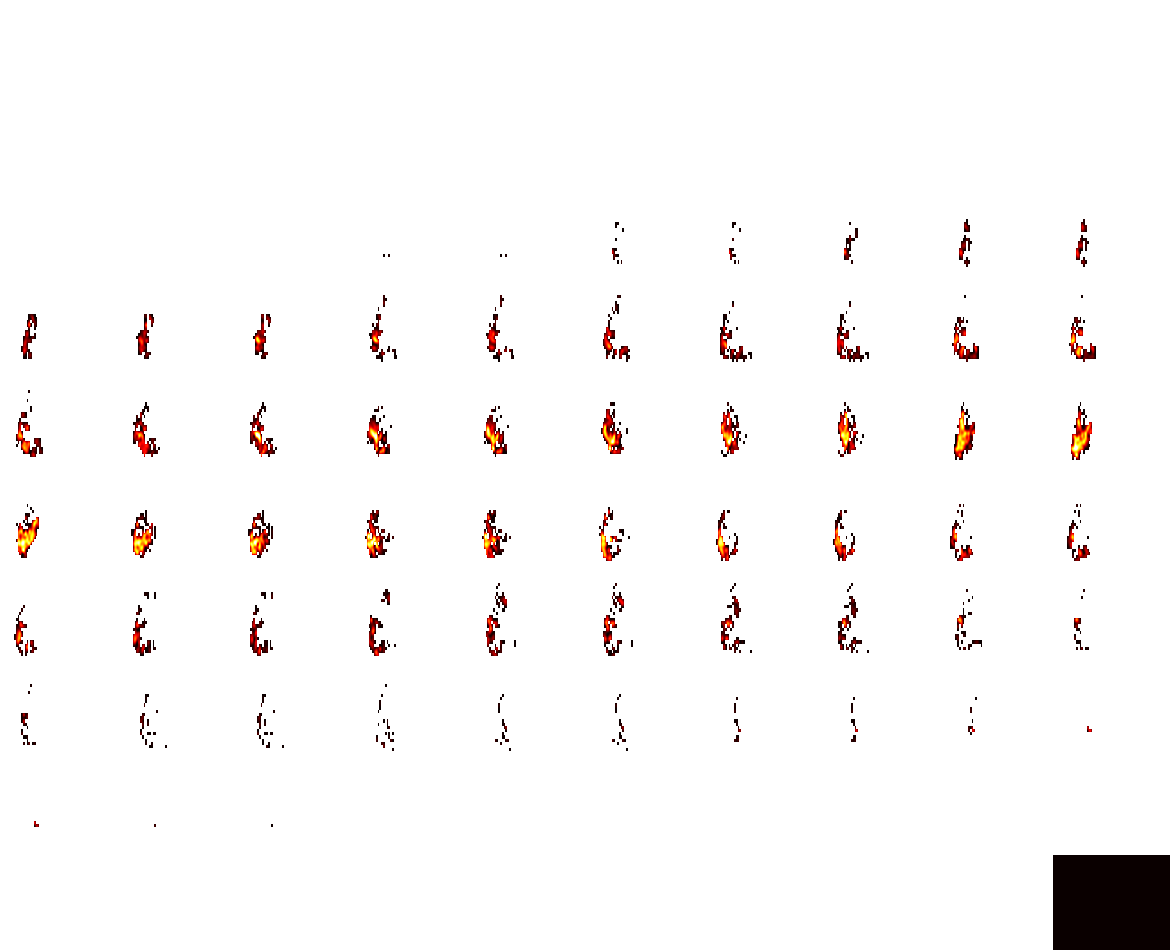

In [30]:
from nilearn import image
from nilearn import plotting

plot = plotting.view_img(thresholded_score_map_img, draw_cross=False, symmetric_cmap=False, cmap=plotting.cm.black_red)
plot

We them plotting the statistical map on a background brain along only z for closer analysis.
We mark four voxels (with outlines blue, green, red, pink) which we will inspect more closely in the next section.



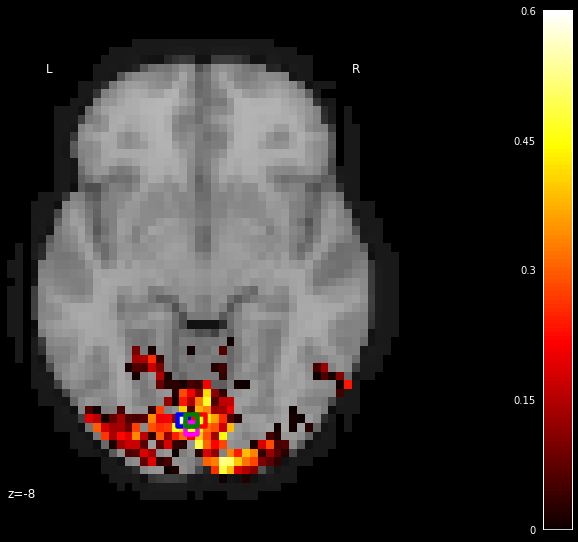

In [31]:
from nilearn.plotting import plot_stat_map
from nilearn.image import coord_transform

def index_to_xy_coord(x, y, z=10):
    '''Transforms data index to coordinates of the background + offset'''
    coords = coord_transform(x, y, z,
                             affine=thresholded_score_map_img.affine)
    return np.array(coords)[np.newaxis, :] + np.array([0, 1, 0])


xy_indices_of_special_voxels = [(30, 10), (32, 10), (31, 9), (31, 10)]

display = plot_stat_map(thresholded_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z')

# creating a marker for each voxel and adding it to the statistical map

for i, (x, y) in enumerate(xy_indices_of_special_voxels):
    display.add_markers(index_to_xy_coord(x, y), marker_color='none',
                        edgecolor=['b', 'r', 'magenta', 'g'][i],
                        marker_size=140, marker='s',
                        facecolor='none', lw=4.5)


# Re-set figure size after construction so colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(8, 8)
#fig.suptitle('Receptive fields of the marked voxels', fontsize=25)

* We see that all voxels do not respond in the same way to the inputs. The relative prediction scores in different locations for this input can be used to draw some inferences.

* We can observe that among the visual areas defined by the mask, only few locations deem. These seem to be concentrated around the visual cortices. This means that the voxels in these regions could potentially encode these fine-grained features such as pixels and/or their positions. It is known from years of study that the early visual areas such as V1, V2, etc. encode such features.

* There are other areas in VT that are not very predictable from the stimulus pixels. This could either mean that the voxels at these locations do not respond depending on these type of stimuli (or) that they do not encode these pixel-level features of the stimuli. For example, they could be more sensitive to images of faces, places, etc. or higher-level concepts/patterns unlike the scrambled image patterns in the stimuli.


## Estimating receptive fields









A voxel's [`receptive field`](http://en.wikipedia.org/wiki/Receptive_field) is the region of a stimulus (like an image) where the presence of an object,
like a white instead of a black pixel, results in a change in activity in the voxel. 

In our case the receptive field is just the vector of 100 regression  coefficients (one for each pixel) reshaped into the 10x10 form of the original images. 

### Receptive fields from the Ridge model

The `model` variable consists of the model fit from the last fold (10th) rom the previous section. Ideally, we average or pick the best fold for a model. But this is good enough for analyzing the coefficients.  

For a given voxel, the coefficients of the linear model can be accessed to obtain 100 dimensional weights that can be visulaized on 10x10 grid corresponding to the stimulus image.

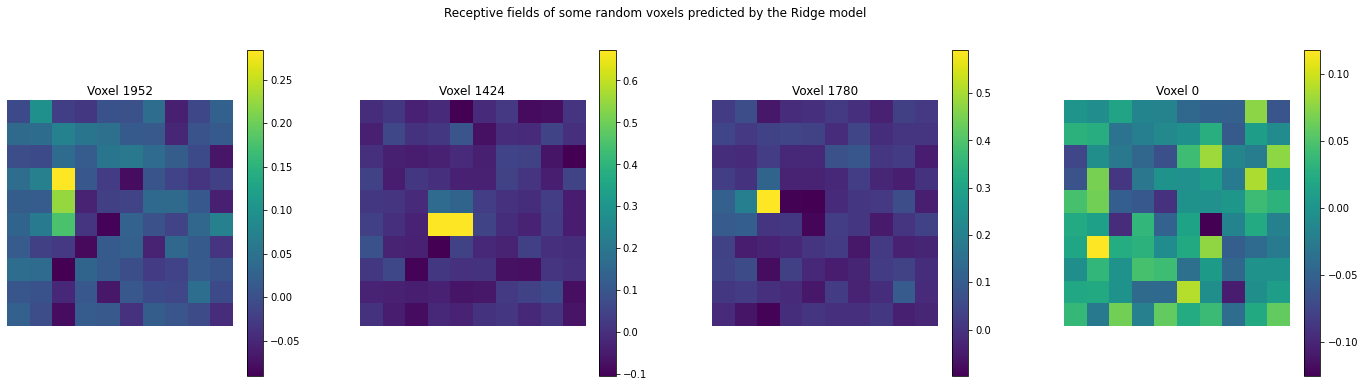

In [46]:
import matplotlib.pyplot as plt


voxels = [1952,1424,1780,0]

num_images = len(voxels)

plt.figure(figsize=(6*num_images, 6))

for j in range(num_images):
    plt.subplot(1, num_images, j+1)
    plt.imshow(model.coef_[voxels[j]].reshape(10,10))
    plt.axis('off')
    plt.title('Voxel {}'.format(voxels[j]))
    plt.colorbar()

plt.subplots_adjust(wspace=0.25)
plt.suptitle('Receptive fields of some random voxels predicted by the Ridge model');

We see that some voxels such as (1952,1424,etc.) have a peak value at one or two pixels only and most other pixel weights are closer to zero.

Whereas for other voxels such as (0, 60, etc.) there is no clear pattern or sellectivity and also the maximum value is very low.

Let us now take a look at the receptive fields of the four marked voxels:

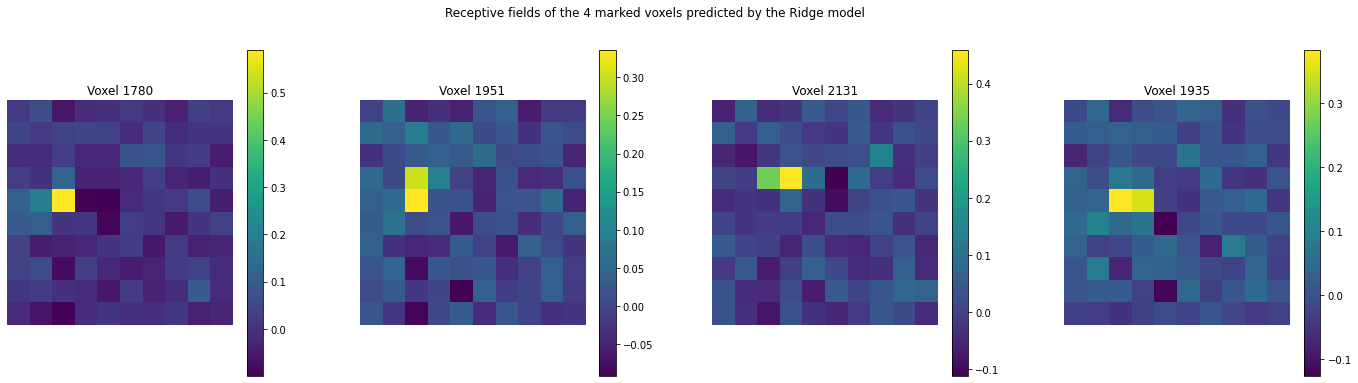

In [45]:
import matplotlib.pyplot as plt


voxels = [1780, 1951, 2131, 1935] 

num_images = len(voxels)

plt.figure(figsize=(6*num_images, 6))

for j in range(num_images):
    plt.subplot(1, num_images, j+1)
    plt.imshow(model.coef_[voxels[j]].reshape(10,10))
    plt.axis('off')
    plt.title('Voxel {}'.format(voxels[j]))
    plt.colorbar()

plt.subplots_adjust(wspace=0.25)
plt.suptitle('Receptive fields of the 4 marked voxels predicted by the Ridge model');

We see that rach of them have a strong selectivity to specific pixel locations, while they do not seem to attend to th other pixels.

### Receptive fields from Lasso model

Now we take a closer look at the receptive fields of the four marked voxels.

Some voxels are receptive to only very few pixels, so we use [`Lasso regression`](http://en.wikipedia.org/wiki/Lasso_(statistic)) to estimate a sparse
set of regression coefficients. We do so to eliminate any insignficant weights to other pixels and see if we recover similar selectivities.

Lasso not only minimizes the values of coefficients, it also brings some of them to zero. This helps us get a clear and distinct picture of the pixel selectivities. 

We will use the [`LassoLarsCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsCV.html) model from scikit-learn for this and plot the receptive fields of the 4 selected voxels. This procedure is very similar to the Ridge fit, but it is done automatically.


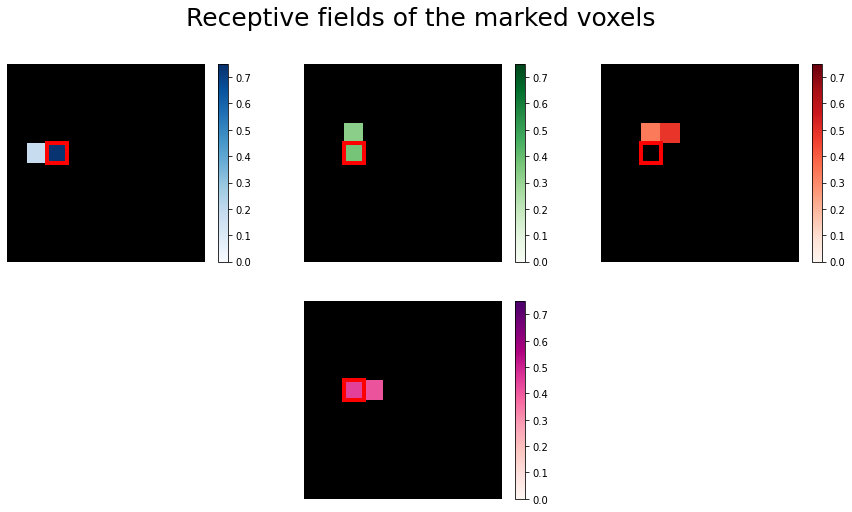

In [47]:
from sklearn.linear_model import LassoLarsCV

# Automatically estimate the sparsity by cross-validation
lasso = LassoLarsCV(max_iter=10)

# Index values of the voxels marked above
voxels = [1780, 1951, 2131, 1935]

# Mark the same pixel in each receptive field
marked_pixel = (4, 2)

from matplotlib import gridspec
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(12, 8))
fig.suptitle('Receptive fields of the marked voxels', fontsize=25)

# GridSpec allows us to do subplots with more control of the spacing
gs = gridspec.GridSpec(2, 3)

# Fit the Lasso for each of the three voxels of the upper row
for i, index in enumerate(voxels[:3]):

    ax = plt.subplot(gs[0, i])

    # Compute receptive field by fitting a lasso model for the encoding 
    # Reshape the coefficients into the form of the original images

    lasso_fit = lasso.fit(stimuli_data, fmri_data[:, index])
    rf = lasso_fit.coef_.reshape((10, 10))

    # add a black background
    ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
    ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                      cmap=['Blues', 'Greens', 'Reds'][i], vmin=0., vmax=0.75)
    # add the marked pixel
    ax.add_patch(Rectangle(
        (marked_pixel[1] - .5, marked_pixel[0] - .5), 1, 1,
        facecolor='none', edgecolor='r', lw=4))
    plt.axis('off')
    plt.colorbar(ax_im, ax=ax)

# and then for the voxel at the bottom

gs.update(left=0., right=1., wspace=0.1)
ax = plt.subplot(gs[1, 1])
# Reshape the coefficients into the form of the original images
lasso_fit = lasso.fit(stimuli_data, fmri_data[:, voxels[3]])
rf = lasso_fit.coef_.reshape((10, 10))

ax.imshow(np.zeros_like(rf), vmin=0., vmax=1., cmap='gray')
ax_im = ax.imshow(np.ma.masked_less(rf, 0.1), interpolation="nearest",
                  cmap='RdPu', vmin=0., vmax=0.75)

# add the marked pixel
ax.add_patch(Rectangle(
    (marked_pixel[1] - .5, marked_pixel[0] - .5), 1, 1,
    facecolor='none', edgecolor='r', lw=4))
plt.axis('off')
plt.colorbar(ax_im, ax=ax);

The receptive fields of the four voxels are not only close to each other,
the relative location of the pixel each voxel is most sensitive to
roughly maps to the relative location of the voxels to each other.
We can see a relationship between some voxel's receptive field and
its location in the brain.



## Evaluation of the encoding model on a test dataset

We will now use another set of runs which used slightly different stimuli distribution of "figures" (non-random images) as opposed to the random pattern images that it was trained on.

There are the first 12 runs in both the fmri and stimulus data.

### Data Preparation 

We will do the same procedure for extracting the data and preparing the data matrices for the evaluation.

Getting the file paths of these data.

In [48]:
# Training data is the first 12 files

fmri_figure_runs_filenames, stimuli_figure_runs_filenames = dataset.func[:12], dataset.label[:12]

Using the masker to extract the fmri time series data of the "figure" runs.

In [49]:
fmri_figure_data = masker.transform(fmri_figure_runs_filenames)

Extract the stimulus images of the "figure" runs.

In [50]:
stimulus_shape = (10, 10)

# We load the visual stimuli from csv files
stimuli_figure_data = []
for stimulus_run in stimuli_figure_runs_filenames:
    stimuli_figure_data.append(np.reshape(np.loadtxt(stimulus_run,
                              dtype=np.int, delimiter=','),
                              (-1,) + stimulus_shape, order='F'))

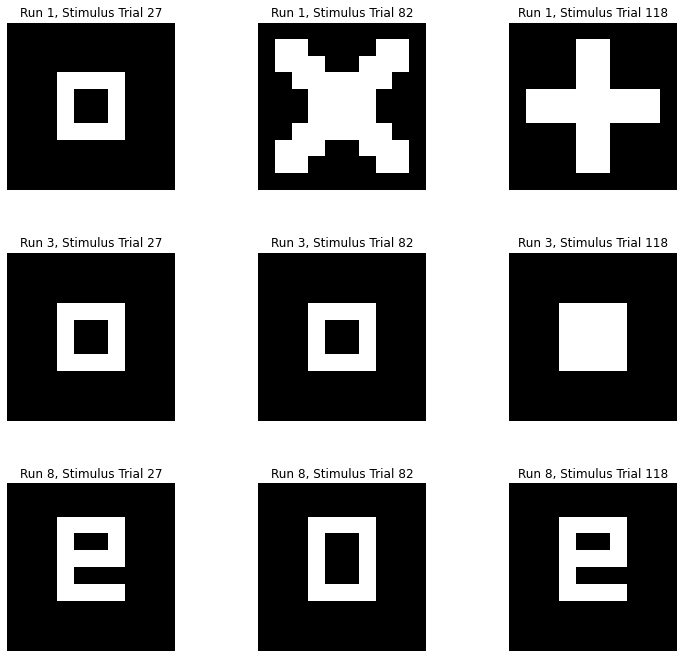

In [51]:
import pylab as plt

runs = [1,3,8]
trials = [27,82,118]

num_runs = len(runs)
num_images = len(trials)

subplot_index = 1

plt.figure(figsize=(4*num_images, 4*num_runs))

for i in range(num_runs):
  for j in range(num_images):
    plt.subplot(num_runs, num_images, subplot_index)
    plt.imshow(stimuli_figure_data[runs[i]][trials[j]], interpolation='nearest', cmap='gray')
    plt.axis('off')
    plt.title('Run {}, Stimulus Trial {}'.format(runs[i],trials[j]))
    subplot_index += 1

plt.subplots_adjust(wspace=0.5)

To account for the hemodynamic delay, shift the data by a certain number.

In [52]:
# Delay chosen based on the TR duration to expect a hemodynamic response
delay_trials = 2

fmri_figure_data = np.vstack([fmri_run[delay_trials:] for fmri_run in fmri_figure_data])
stimuli_figure_data = np.vstack([stimuli_run[:-delay_trials] for stimuli_run in stimuli_figure_data]).astype(float)

Flatten the stimuli and verify that inputs and targets are equal in number.

In [53]:
# Flatten the stimuli

stimuli_figure_data = np.reshape(stimuli_figure_data, (-1, stimulus_shape[0] * stimulus_shape[1]))

print('fmri_figure_data.shape =',fmri_figure_data.shape) 
print('stimuli_figure_data.shape =',stimuli_figure_data.shape)

fmri_figure_data.shape = (1536, 5438)
stimuli_figure_data.shape = (1536, 100)


### Scoring the test set using the encoding model

Use the trained encoding model to predict for the test simuli.

Consider the actual fmri data extracted for the test set and compute the R2 score.

In [54]:
from sklearn.metrics import r2_score

actual = fmri_figure_data
predicted = model.predict(stimuli_figure_data)

test_score_map = r2_score(actual, predicted, multioutput='raw_values')

Create the thresholded image for plotting.

In [57]:
from nilearn.image import threshold_img

# Ignore the negative score values 
test_score_map[test_score_map < 0] = 0

# Bring the scores into the shape of the background brain
test_score_map_img = masker.inverse_transform(test_score_map)

thresholded_test_score_map_img = threshold_img(test_score_map_img, threshold=1e-6, copy=False)


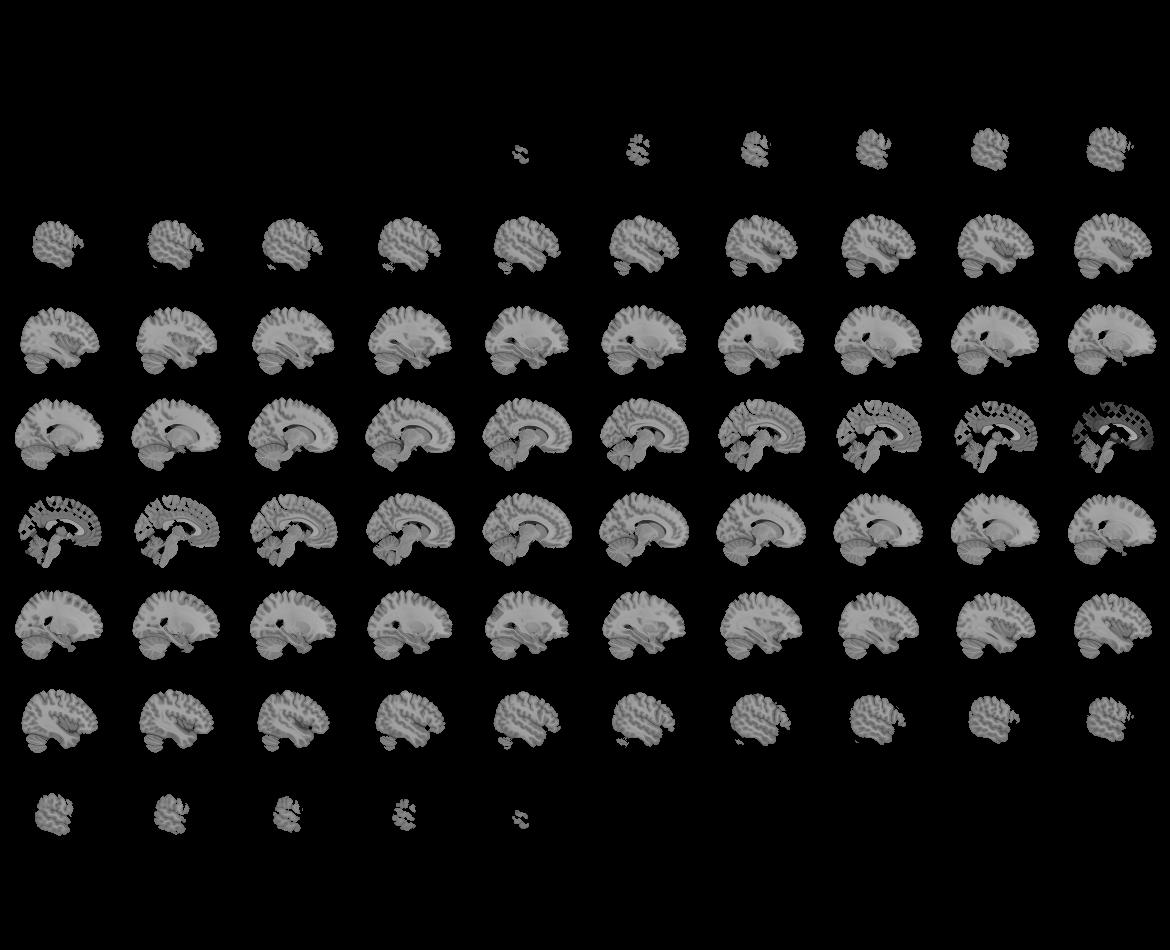
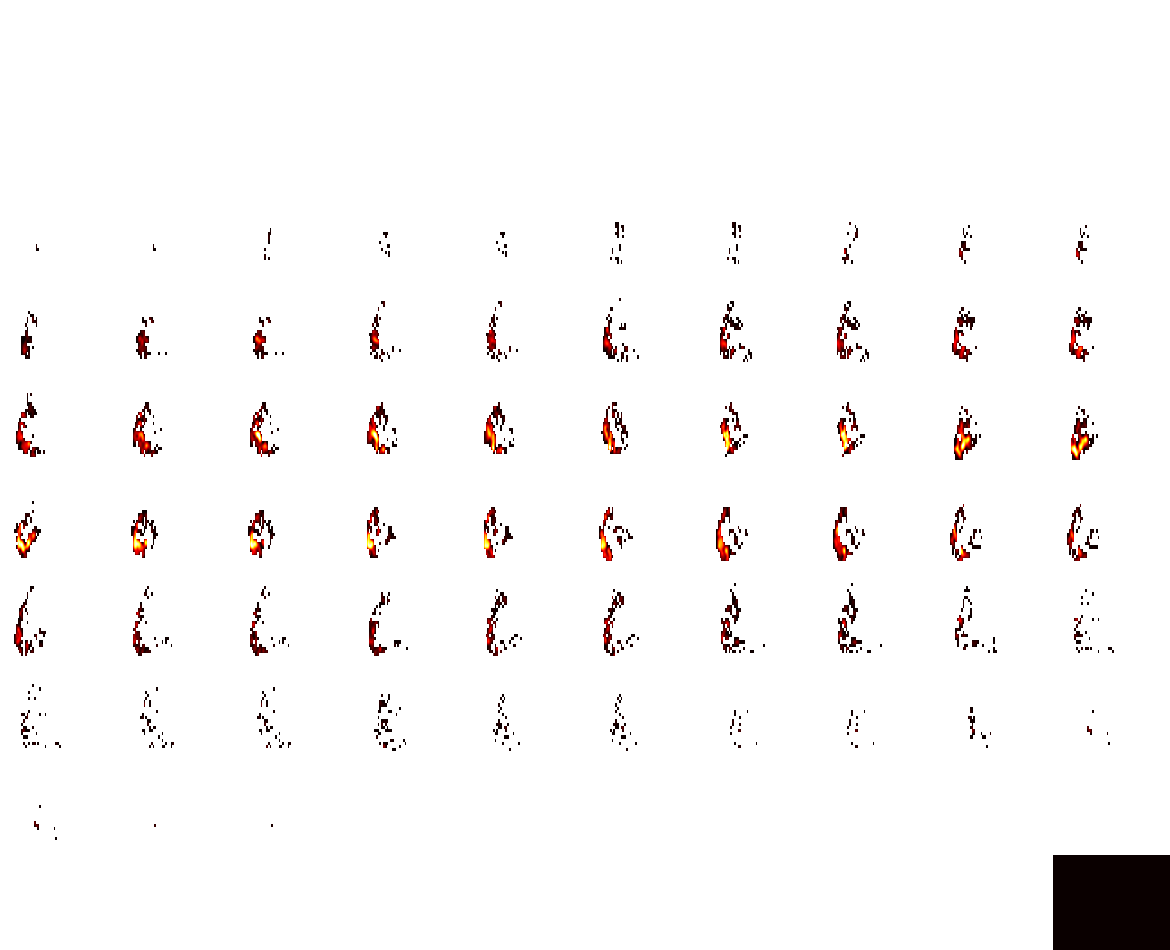

In [59]:
from nilearn import image
from nilearn import plotting

plot = plotting.view_img(thresholded_test_score_map_img, draw_cross=False, symmetric_cmap=False, cmap=plotting.cm.black_red)
plot

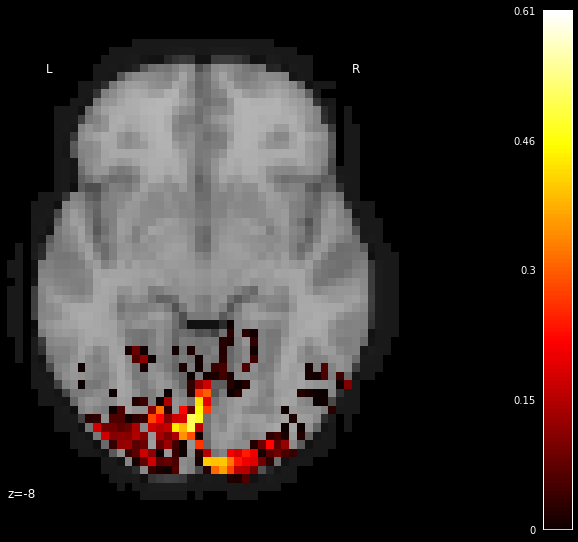

In [60]:
from nilearn.plotting import plot_stat_map
from nilearn.image import coord_transform

display = plot_stat_map(thresholded_test_score_map_img, bg_img=dataset.background,
                        cut_coords=[-8], display_mode='z')

# creating a marker for each voxel and adding it to the statistical map

# Re-set figure size after construction so colorbar gets rescaled too
fig = plt.gcf()
fig.set_size_inches(8, 8)

We can see that the encoding model predicts similar predictability for this unseen stimulus set. 

This means that it has learned the stimulus image pixel to brain voxel associations very well and identifies the voxels that are more responsive to the input pixels.